In [8]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy import signal
from astropy.io import fits
from sklearn.decomposition import FastICA
import cv2

In [54]:
in_path_fg = "./foregrounds/FastICA_Data/"
in_path_cs = "./foregrounds/FastICA_Data/"

output_path = "./foregrounds/FastICA_Data/"
fname_all = "test_filename"


fname_foreground = "foregrounds_total"
fname_cs = "observer_lightcone"
fname_noise = "noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K"


indata_fg = fits.getdata(in_path_fg+fname_foreground+'.fits')

indata_cs = fits.getdata(in_path_cs+fname_cs+'.fits')
indata_cs = indata_cs/1000 # 21cmFAST are in mK by default, convert to K

indata_noise = fits.getdata(in_path_cs+fname_noise+'.fits')
indata_noise = indata_noise[:316, :, :]
arr = np.zeros((316,150,150))
for i in range(316):
    arr[i,:,:] = cv2.resize((indata_noise[i,:,:]-np.min(indata_noise[i,:,:])), (150, 150))+np.min(indata_noise[i,:,:])



indata_fg = indata_fg.transpose(2, 0, 1)
indata_cs = indata_cs.transpose(2, 0, 1)
indata_noise = arr
    

sh = indata_fg.shape
print(sh)
print(np.shape(arr))

(316, 150, 150)
(316, 150, 150)


-0.09347645473374737
-0.07960116878149033


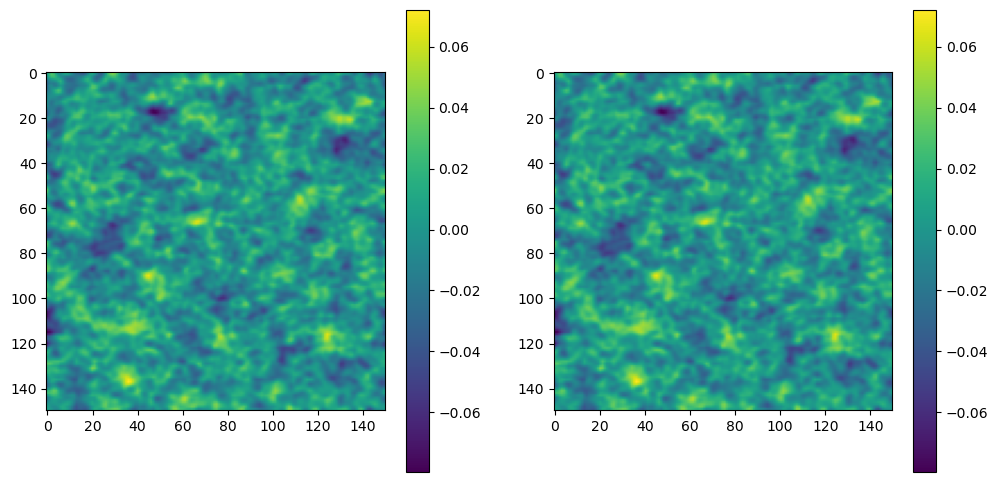

In [55]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(arr[0,:,:])
plt.colorbar()

plt.subplot(122)
plt.imshow((indata_noise[0,:,:]))
plt.colorbar()

print(np.min(arr))
print(np.min(indata_noise[0,:,:]))

In [58]:
ncomp = 4

indata = indata_fg + indata_cs + indata_noise

sh = indata.shape
print(sh)
X = np.reshape(indata,(sh[0], sh[1]*sh[2]))

ica1 = FastICA(n_components=ncomp)
model1 = []
S = ica1.fit_transform(X.T)  # Reconstruct signals
A = ica1.mixing_  # Get estimated mixing matrix

model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))

res =  indata-model1


rec =  indata-res

(316, 150, 150)


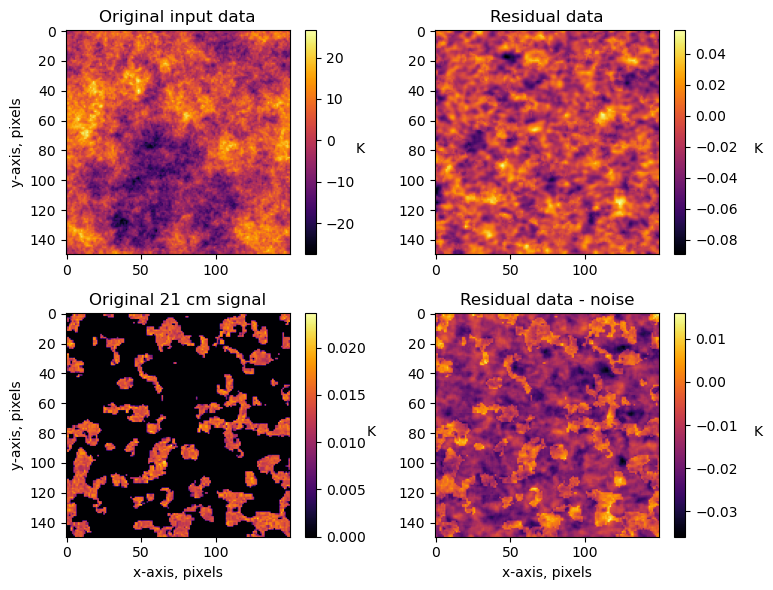

In [63]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.imshow(indata[0], cmap='inferno')
plt.title('Original input data')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0)
plt.ylabel('y-axis, pixels')

plt.subplot(222)
plt.imshow(res[0], cmap='inferno')
plt.title('Residual data')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0, labelpad=15)

plt.subplot(223)
plt.imshow(indata_cs[0], cmap='inferno')
plt.title('Original 21 cm signal')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0)
plt.xlabel('x-axis, pixels')
plt.ylabel('y-axis, pixels')

plt.subplot(224)
plt.imshow(res[0]-indata_noise[0], cmap='inferno')
plt.title('Residual data - noise')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0, labelpad=15)
plt.xlabel('x-axis, pixels')

plt.tight_layout()

/Users/dmitryzenko/miniconda3/envs/cm21fast/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/dmitryzenko/miniconda3/envs/cm21fast/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


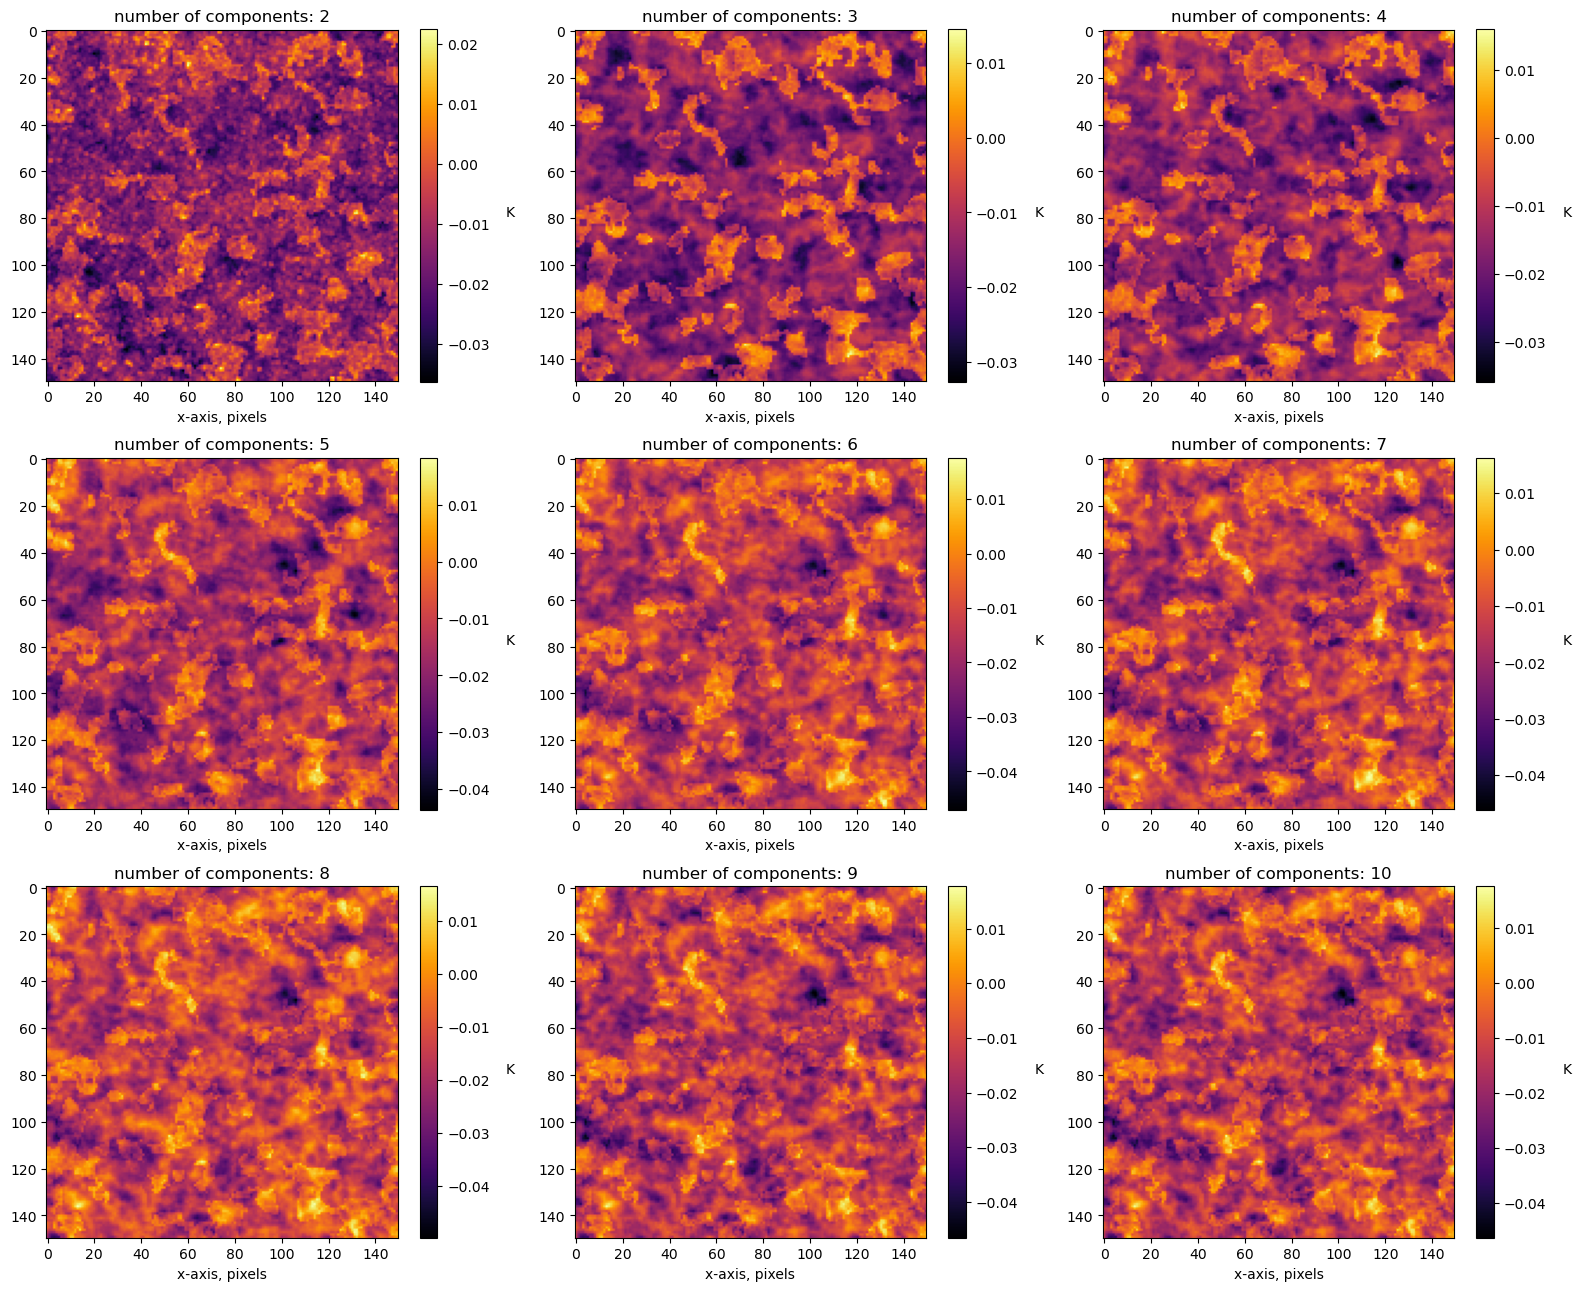

In [71]:
plt.figure(figsize=(16,13))

for ncomp in range(2,11):
    
    ica1 = FastICA(n_components=ncomp)
    model1 = []
    S = ica1.fit_transform(X.T)  # Reconstruct signals
    A = ica1.mixing_  # Get estimated mixing matrix

    model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))

    res =  indata-model1

    plt.subplot(3,3,ncomp-1)
    plt.imshow(res[0]-indata_noise[0], cmap='inferno')
    plt.title('number of components: {}'.format(ncomp))
    cbar = plt.colorbar()
    cbar.set_label('K', rotation=0, labelpad=15)
    plt.xlabel('x-axis, pixels')
    
plt.tight_layout()
plt.show()
    

# Power spectrum

In [74]:
import tools21cm as tc

In [73]:
ica1 = FastICA(n_components=3) # 3 deduced to be the best from previous cells
model1 = []
S = ica1.fit_transform(X.T)  # Reconstruct signals
A = ica1.mixing_  # Get estimated mixing matrix

model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))



In [129]:
res =  indata-model1
noise = np.copy(indata_noise)
cosm = np.copy(indata_cs)

P_res, k_res = tc.power_spectrum_1d(res, kbins=100, box_dims=500)
P_noise, k_noise = tc.power_spectrum_1d(noise, kbins=100, box_dims=500)
P_cosm, k_cosm = tc.power_spectrum_1d(cosm, kbins=100, box_dims=500)

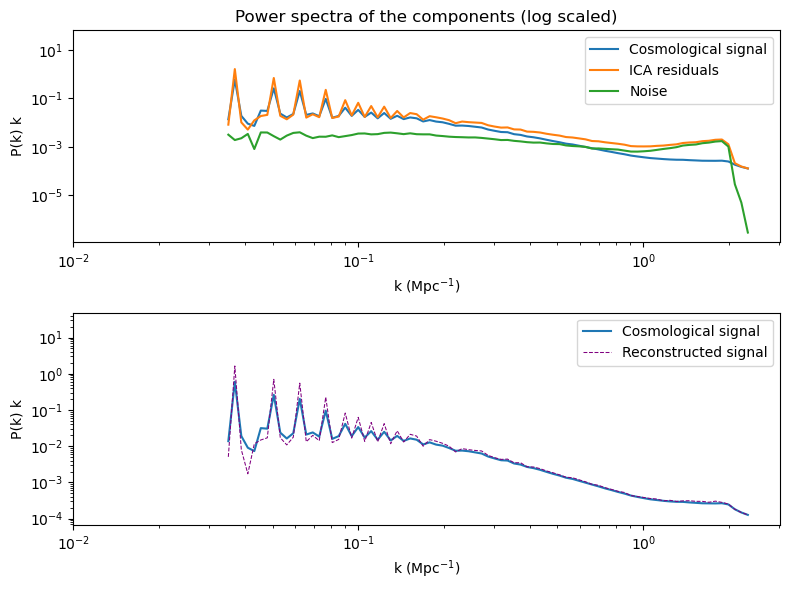

In [162]:
plt.figure(figsize = (8,6))
plt.subplot(211)
plt.title('Power spectra of the components (log scaled)')
plt.loglog(k_cosm, P_cosm*k_cosm, label='Cosmological signal')
plt.loglog(k_res, P_res*k_res, label='ICA residuals')
plt.loglog(k_noise, P_noise*k_noise, label='Noise')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k')
plt.legend()

P_rec = P_res - P_noise

plt.subplot(212)
plt.loglog(k_cosm, P_cosm*k_cosm, label='Cosmological signal')
plt.loglog(k_res, P_rec*k_res,'--',color='purple', linewidth=0.75,label='Reconstructed signal')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k')
plt.legend()

plt.tight_layout()